In [1]:
#https://hichoe95.tistory.com/9와 비교하면 재밌을듯

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable

plt.ion()   # interactive mode

In [3]:
#임의로 8:2로 나눔
#Kaggle dogs and cats
trainset = datasets.ImageFolder(root="./data/dogs-vs-cats/train/",
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
class_names = trainset.classes

testset = datasets.ImageFolder(root="./data/dogs-vs-cats/test/",
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

torch.Size([4, 3, 224, 224]) tensor([0, 0, 1, 0])


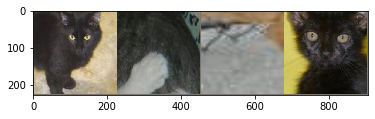

  cat   cat   dog   cat


In [5]:
def imshow(img):
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
    img = unorm(img) # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size(), labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1, 1) #6*224*224
        #pool
        self.conv2 = nn.Conv2d(6, 16, 3, 1, 1) #16*112*112
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1) #32*56*56
        #pool
        
        self.fc1 = nn.Linear(32 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 32 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)

In [8]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  net = nn.DataParallel(net)
 
if torch.cuda.is_available():
   net.cuda()

lossPlot = []

for epoch in range(20):  # loop over the dataset multiple times

    correct = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        prediction = torch.max(outputs.data,1)[1]
        #print(torch.max(outputs.data,1)[0])
        #print(torch.max(outputs.data,1)[1])
        #print(torch.max(outputs.data,0))
        #print(torch.max(outputs.data,1))
        #print(torch.max(outputs.data,-1))
        #print(torch.max(outputs.data,-2))
        
        
        correct += prediction.eq(labels.data.view_as(prediction)).cpu().sum()
        #print(prediction)
        #print(labels.data.view_as(prediction))
        #print(prediction.eq(labels.data.view_as(prediction)).cpu())
        #print(prediction.eq(labels.data.view_as(prediction)).cpu().sum())
        #print 3개 : tensor([0, 1, 0, 1], device='cuda:0'), tensor([0, 0, 1, 1], device='cuda:0'), tensor(2)
        
        if i % 250 == 249:    # print every 250 mini-batches -> 원래 2000
            print('[%d, %5d] loss: %.6f acc : %.6f' % (epoch + 1, i+1, running_loss/250, 100*correct/((i+1)*4)))
            lossPlot.append(running_loss/250)
            running_loss = 0.0

print('Finished Training')

[1,   250] loss: 0.692685 acc : 51.000000
[1,   500] loss: 0.692421 acc : 51.000000
[1,   750] loss: 0.693255 acc : 51.000000
[1,  1000] loss: 0.692769 acc : 50.000000
[1,  1250] loss: 0.692119 acc : 51.000000
[1,  1500] loss: 0.691863 acc : 51.000000
[1,  1750] loss: 0.691554 acc : 52.000000
[1,  2000] loss: 0.690890 acc : 52.000000
[1,  2250] loss: 0.690749 acc : 52.000000
[1,  2500] loss: 0.691278 acc : 52.000000
[1,  2750] loss: 0.687906 acc : 52.000000
[1,  3000] loss: 0.689618 acc : 52.000000
[1,  3250] loss: 0.687477 acc : 53.000000
[1,  3500] loss: 0.687007 acc : 53.000000
[1,  3750] loss: 0.683566 acc : 53.000000
[1,  4000] loss: 0.685591 acc : 53.000000
[1,  4250] loss: 0.684192 acc : 53.000000
[1,  4500] loss: 0.678805 acc : 53.000000
[1,  4750] loss: 0.673017 acc : 54.000000
[1,  5000] loss: 0.673806 acc : 54.000000
[2,   250] loss: 0.670739 acc : 59.000000
[2,   500] loss: 0.660731 acc : 61.000000
[2,   750] loss: 0.666373 acc : 60.000000
[2,  1000] loss: 0.677951 acc : 59

[10,  3750] loss: 0.536353 acc : 71.000000
[10,  4000] loss: 0.554443 acc : 71.000000
[10,  4250] loss: 0.540308 acc : 71.000000
[10,  4500] loss: 0.538667 acc : 71.000000
[10,  4750] loss: 0.545389 acc : 71.000000
[10,  5000] loss: 0.532574 acc : 71.000000
[11,   250] loss: 0.532067 acc : 74.000000
[11,   500] loss: 0.542455 acc : 73.000000
[11,   750] loss: 0.537183 acc : 73.000000
[11,  1000] loss: 0.547920 acc : 72.000000
[11,  1250] loss: 0.549188 acc : 72.000000
[11,  1500] loss: 0.524665 acc : 72.000000
[11,  1750] loss: 0.515077 acc : 72.000000
[11,  2000] loss: 0.536506 acc : 73.000000
[11,  2250] loss: 0.561254 acc : 72.000000
[11,  2500] loss: 0.524955 acc : 72.000000
[11,  2750] loss: 0.547414 acc : 72.000000
[11,  3000] loss: 0.526461 acc : 72.000000
[11,  3250] loss: 0.531469 acc : 72.000000
[11,  3500] loss: 0.554465 acc : 72.000000
[11,  3750] loss: 0.530077 acc : 72.000000
[11,  4000] loss: 0.510611 acc : 72.000000
[11,  4250] loss: 0.532896 acc : 72.000000
[11,  4500]

[20,  1250] loss: 0.478473 acc : 74.000000
[20,  1500] loss: 0.497994 acc : 75.000000
[20,  1750] loss: 0.484665 acc : 75.000000
[20,  2000] loss: 0.464148 acc : 75.000000
[20,  2250] loss: 0.482982 acc : 75.000000
[20,  2500] loss: 0.511004 acc : 75.000000
[20,  2750] loss: 0.469216 acc : 75.000000
[20,  3000] loss: 0.501133 acc : 75.000000
[20,  3250] loss: 0.475575 acc : 75.000000
[20,  3500] loss: 0.487557 acc : 75.000000
[20,  3750] loss: 0.477202 acc : 75.000000
[20,  4000] loss: 0.455301 acc : 75.000000
[20,  4250] loss: 0.490021 acc : 75.000000
[20,  4500] loss: 0.490556 acc : 75.000000
[20,  4750] loss: 0.482471 acc : 75.000000
[20,  5000] loss: 0.457863 acc : 75.000000
Finished Training


In [10]:
for epoch in range(20):  # loop over the dataset multiple times

    correct = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        prediction = torch.max(outputs.data,1)[1]
        #print(torch.max(outputs.data,1)[0])
        #print(torch.max(outputs.data,1)[1])
        #print(torch.max(outputs.data,0))
        #print(torch.max(outputs.data,1))
        #print(torch.max(outputs.data,-1))
        #print(torch.max(outputs.data,-2))
        
        
        correct += prediction.eq(labels.data.view_as(prediction)).cpu().sum()
        #print(prediction)
        #print(labels.data.view_as(prediction))
        #print(prediction.eq(labels.data.view_as(prediction)).cpu())
        #print(prediction.eq(labels.data.view_as(prediction)).cpu().sum())
        #print 3개 : tensor([0, 1, 0, 1], device='cuda:0'), tensor([0, 0, 1, 1], device='cuda:0'), tensor(2)
        
        if i % 250 == 249:    # print every 250 mini-batches -> 원래 2000
            print('[%d, %5d] loss: %.6f acc : %.6f' % (epoch + 21, i+1, running_loss/250, 100*correct/((i+1)*4)))
            lossPlot.append(running_loss/250)
            running_loss = 0.0

print('Finished Training - Again')

[21,   250] loss: 0.498666 acc : 75.000000
[21,   500] loss: 0.491966 acc : 75.000000
[21,   750] loss: 0.494517 acc : 75.000000
[21,  1000] loss: 0.501078 acc : 75.000000
[21,  1250] loss: 0.490223 acc : 75.000000
[21,  1500] loss: 0.470924 acc : 75.000000
[21,  1750] loss: 0.484072 acc : 75.000000
[21,  2000] loss: 0.464053 acc : 75.000000
[21,  2250] loss: 0.466236 acc : 75.000000
[21,  2500] loss: 0.461551 acc : 75.000000
[21,  2750] loss: 0.462336 acc : 76.000000
[21,  3000] loss: 0.449619 acc : 76.000000
[21,  3250] loss: 0.470012 acc : 76.000000
[21,  3500] loss: 0.490450 acc : 76.000000
[21,  3750] loss: 0.485511 acc : 76.000000
[21,  4000] loss: 0.487444 acc : 76.000000
[21,  4250] loss: 0.513663 acc : 76.000000
[21,  4500] loss: 0.495705 acc : 76.000000
[21,  4750] loss: 0.479647 acc : 76.000000
[21,  5000] loss: 0.465548 acc : 76.000000
[22,   250] loss: 0.459073 acc : 77.000000
[22,   500] loss: 0.485861 acc : 76.000000
[22,   750] loss: 0.490825 acc : 76.000000
[22,  1000]

[30,  2750] loss: 0.446222 acc : 78.000000
[30,  3000] loss: 0.456425 acc : 78.000000
[30,  3250] loss: 0.427737 acc : 78.000000
[30,  3500] loss: 0.432732 acc : 78.000000
[30,  3750] loss: 0.428900 acc : 78.000000
[30,  4000] loss: 0.470770 acc : 78.000000
[30,  4250] loss: 0.464473 acc : 78.000000
[30,  4500] loss: 0.458856 acc : 78.000000
[30,  4750] loss: 0.458747 acc : 78.000000
[30,  5000] loss: 0.431982 acc : 78.000000
[31,   250] loss: 0.472846 acc : 76.000000
[31,   500] loss: 0.457434 acc : 77.000000
[31,   750] loss: 0.443830 acc : 77.000000
[31,  1000] loss: 0.441878 acc : 78.000000
[31,  1250] loss: 0.427504 acc : 78.000000
[31,  1500] loss: 0.446264 acc : 78.000000
[31,  1750] loss: 0.462775 acc : 78.000000
[31,  2000] loss: 0.425075 acc : 78.000000
[31,  2250] loss: 0.479714 acc : 78.000000
[31,  2500] loss: 0.475829 acc : 78.000000
[31,  2750] loss: 0.445152 acc : 78.000000
[31,  3000] loss: 0.444107 acc : 78.000000
[31,  3250] loss: 0.463288 acc : 78.000000
[31,  3500]

[40,   250] loss: 0.420874 acc : 80.000000
[40,   500] loss: 0.425898 acc : 80.000000
[40,   750] loss: 0.432028 acc : 80.000000
[40,  1000] loss: 0.393688 acc : 80.000000
[40,  1250] loss: 0.398444 acc : 81.000000
[40,  1500] loss: 0.428436 acc : 80.000000
[40,  1750] loss: 0.423041 acc : 80.000000
[40,  2000] loss: 0.389826 acc : 80.000000
[40,  2250] loss: 0.430501 acc : 80.000000
[40,  2500] loss: 0.423395 acc : 80.000000
[40,  2750] loss: 0.413661 acc : 80.000000
[40,  3000] loss: 0.416888 acc : 80.000000
[40,  3250] loss: 0.404765 acc : 80.000000
[40,  3500] loss: 0.402876 acc : 80.000000
[40,  3750] loss: 0.415647 acc : 80.000000
[40,  4000] loss: 0.429179 acc : 80.000000
[40,  4250] loss: 0.423830 acc : 80.000000
[40,  4500] loss: 0.424222 acc : 80.000000
[40,  4750] loss: 0.419024 acc : 80.000000
[40,  5000] loss: 0.398396 acc : 80.000000
Finished Training - Again


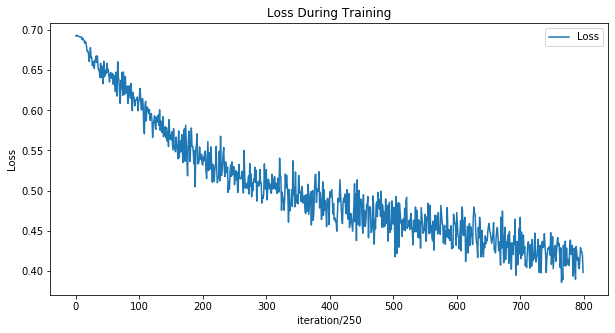

In [11]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(lossPlot,label="Loss")
plt.xlabel("iteration/250")
plt.ylabel("Loss")
plt.legend()
plt.show()

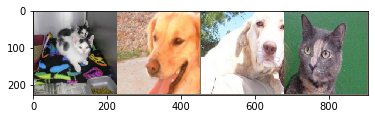

GroundTruth:    cat   dog   dog   cat


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [13]:
images, labels = Variable(images.cuda()), Variable(labels.cuda()) #이거 안하면 안도는데 잘못헀나 싶기도
outputs = net(images)

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(4)))

Predicted:    dog   cat   dog   cat


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 2500 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 2500 test images: 79 %


In [16]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 86 %
Accuracy of   dog : 72 %


In [28]:
#print(net.state_dict())
#print(net.eval())
torch.save(net, "./save")

In [29]:
net.state_dict()

OrderedDict([('conv1.weight', tensor([[[[-0.2441, -0.2778, -0.2062],
                        [-0.0332, -0.0190, -0.0407],
                        [-0.1217, -0.0447,  0.1399]],
              
                       [[-0.2346, -0.1734,  0.0174],
                        [-0.1237,  0.0874, -0.1303],
                        [ 0.2598,  0.2698,  0.1834]],
              
                       [[-0.1711,  0.2013, -0.0108],
                        [ 0.2390,  0.1699,  0.2012],
                        [ 0.3731,  0.4240,  0.2861]]],
              
              
                      [[[-0.1657, -0.3149, -0.3521],
                        [-0.0936, -0.0921, -0.2579],
                        [-0.0253, -0.3142, -0.0846]],
              
                       [[ 0.0237, -0.0080, -0.4019],
                        [ 0.1336, -0.0912, -0.2492],
                        [ 0.0127, -0.2033, -0.3646]],
              
                       [[ 0.4443,  0.3079,  0.1879],
                        [ 0.3296,  0.270